In [1]:
import pickle
import glob
import json

import numpy as np
import bilby
import corner
import matplotlib.pyplot as plt
from enterprise.pulsar import Pulsar
from enterprise.signals import selections
from enterprise.signals import utils
design = utils.createfourierdesignmatrix_red
import enterprise.constants as const

### Load enterprise pulsar

In [2]:
with open('/Users/zhaoshiyi/Desktop/project/forecast/data/ppta_dr3/32psrs_DE438.pkl', 'rb') as f:
    psrs = pickle.load(f)

psr1909 = [p for p in psrs if p.name == 'J1909-3744']

### Load the red noise posteriori sample

In [3]:
chains = np.loadtxt('/Users/zhaoshiyi/Desktop/project/forecast/data/dr3_noises_posr_tnrn/J1909-3744_tnrn/chain_1.txt')
burnin = int(0.25 * len(chains))
chains_lgA = chains[:, 2]
chains_gamma = chains[:, 1]

### red noise power spectrum

In [4]:
def powerlaw(f, A, gamma, T):

    f1yr = 1 / 3.16e7
    Pf = (A**2 / 12 / np.pi**2 * f1yr**(gamma - 3) * f**(-gamma) / T)
    return np.repeat(Pf, 2)

### Fourier coefficient:

$$\varphi_{red,ij} = \langle a_{\rm red}a_{\rm red}^T \rangle = diag(\{\varphi_{red,i}\})$$

$$a_{red} = \sqrt{P(f)}$$

In [5]:
def get_Fourier_coefficient(lgA, gamma, Tspan, comp=30):
    
    freqs = np.array([i / Tspan for i in range(1, comp + 1)])
    A = 10 ** lgA
    return np.sqrt(powerlaw(freqs, A, gamma, Tspan))

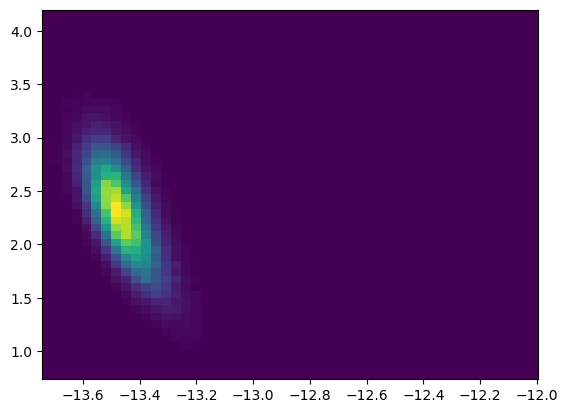

In [6]:
def get_point_pro(chains_lgA, chains_gamma, bins):
    """
    Calculate the noise posteriori distribution
    chains_lgA, chains_gamma: The old sampling chain of red noise parameters lgA and gamma
    bins: int

    return: (lg_Amids, gamids, pro_marx), 
            the value of the parameter in each bin, and the corresponding probability
    """
    distr2d = plt.hist2d(chains_lgA, chains_gamma, bins=bins)
    pro_marx = distr2d[0] / len(chains_lgA)
    lg_Amids = distr2d[1][:-1] / 2 + distr2d[1][1:] / 2
    gamids = distr2d[2][:-1] / 2 + distr2d[2][1:] / 2
    return lg_Amids, gamids, pro_marx

lg_Amids, gamids, pro_marx = get_point_pro(chains_lgA, chains_gamma, bins=50)

### get prob
$$\log(prob) \sim a^T \Phi^{-1} a$$

In [7]:
def prob(lgA, gamma, Tspan, comp=30):
    # a^T \Phi^{-1} a
    coeffic = get_Fourier_coefficient(lgA, gamma, Tspan, comp)
    phi = np.diag(coeffic)
    phiinv = np.linalg.inv(phi)
    # phiinv = pta.get_phiinv(noises)[0]
    return np.dot(np.dot(coeffic.T, phiinv), coeffic)

### create Likelihood

$$L(data|new) = \int \exp(-0.5 * a^T \Phi^{-1} a) * P(old,A,\gamma | data) dA d\gamma d(old)$$
**What's the P(old)?**

In [8]:
class PTARedNoiseLikelihood(bilby.likelihood.Likelihood):
    def __init__(self, Tspan):
        super().__init__()
        self.Tspan = Tspan # The time span we want to predict.
        self.parameters = {'param_lgA': None,
                           'param_gamma': None}

    def log_likelihood(self):
        param_lgA = self.parameters['param_lgA']
        param_gamma = self.parameters['param_gamma']
        prob_value = prob(param_lgA, param_gamma, self.Tspan)
        ln_like = 0
        # The integral simplifies to summation
        for i, lgA in enumerate(lg_Amids):
            for j, gamma in enumerate(gamids):
                point_pro = pro_marx[i][j]
                ln_like += -0.5 * point_pro * prob_value
        # print(ln_like)
        return ln_like

### Set sample and run MCMC

In [9]:
nyrs = 25
Tspan = nyrs*3.16e7
likelihood = PTARedNoiseLikelihood(Tspan=Tspan)

priors = dict(param_lgA = bilby.core.prior.Uniform(-18, -11, "param_lgA"),
              param_gamma = bilby.core.prior.Uniform(0, 7, "param_gamma"))
outdir = f'./outdir_{nyrs}yrs'
result = bilby.run_sampler(
    likelihood=likelihood, priors=priors, sampler="dynesty", nlive=300, 
    label="pta_red_noise", outdir=outdir
)

23:52 bilby INFO    : Running for label 'pta_red_noise', output will be saved to './outdir_25yrs'
23:52 bilby INFO    : Analysis priors:
23:52 bilby INFO    : param_lgA=Uniform(minimum=-18, maximum=-11, name='param_lgA', latex_label='param_lgA', unit=None, boundary=None)
23:52 bilby INFO    : param_gamma=Uniform(minimum=0, maximum=7, name='param_gamma', latex_label='param_gamma', unit=None, boundary=None)
23:52 bilby INFO    : Analysis likelihood class: <class '__main__.PTARedNoiseLikelihood'>
23:52 bilby INFO    : Analysis likelihood noise evidence: nan
23:52 bilby INFO    : Single likelihood evaluation took nan s
23:52 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 300, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None

709it [01:08,  5.23it/s, bound:0 nc: 16 ncall:3.3e+03 eff:21.2% logz=-0.11+/-nan dlogz:0.100>0.1] 

23:54 bilby INFO    : Written checkpoint file ./outdir_25yrs/pta_red_noise_resume.pickle


709it [01:39,  7.09it/s, bound:0 nc:  1 ncall:3.6e+03 eff:30.2% logz=-0.01+/-nan dlogz:0.000>0.1]



23:54 bilby INFO    : Rejection sampling nested samples to obtain 330 posterior samples
23:54 bilby INFO    : Sampling time: 0:01:39.808644
23:54 bilby INFO    : Summary of results:
nsamples: 330
ln_noise_evidence:    nan
ln_evidence: -0.006 +/-  0.004
ln_bayes_factor:    nan +/-  0.004



### plot result

In [10]:
jsfile = f"{outdir}/pta_red_noise_result.json"

result = bilby.result.read_in_result(jsfile, result_class=bilby.core.result.Result)

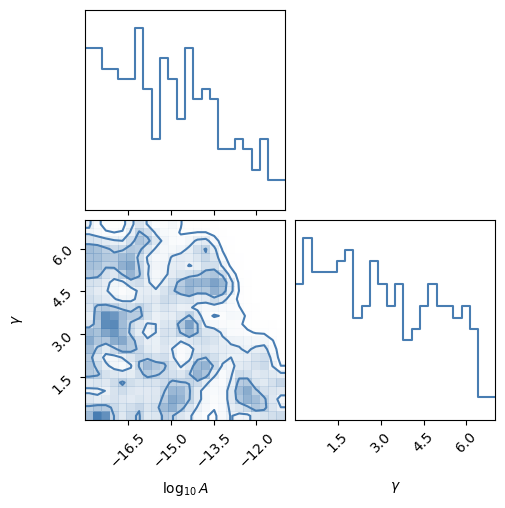

In [11]:
chains = result.samples

burnin_smbbh = int(len(chains) * 0.2)
range_smbbh=((-18, -11), (0, 7))
# _range = ((0, 7), (-18, -11))
bins = 24
# params_smbbh = get_value(chains_smbbh, bins=bins, burnin=burnin_smbbh)
# burnin_smbbh = int(len(chains_smbbh) * 0.1)
fig = corner.corner(chains[burnin_smbbh:, [0, 1]],  
            labels=[r"$\log_{10} A$", r"$\gamma$"],
            plot_density = True,
            plot_datapoints = False,
            smooth = 1, smooth1d=0.5,
            levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)), 
            range=range_smbbh, 
            # truths=(-13.48, 2.32),  
            bins=bins, 
            color='#487DB2',
            quantiles=None, 
            fill_contours=False, max_n_ticks=5, 
        #     fig=fig
            )